# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [4]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

136245
Int64Index([118664], dtype='int64')
136244


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

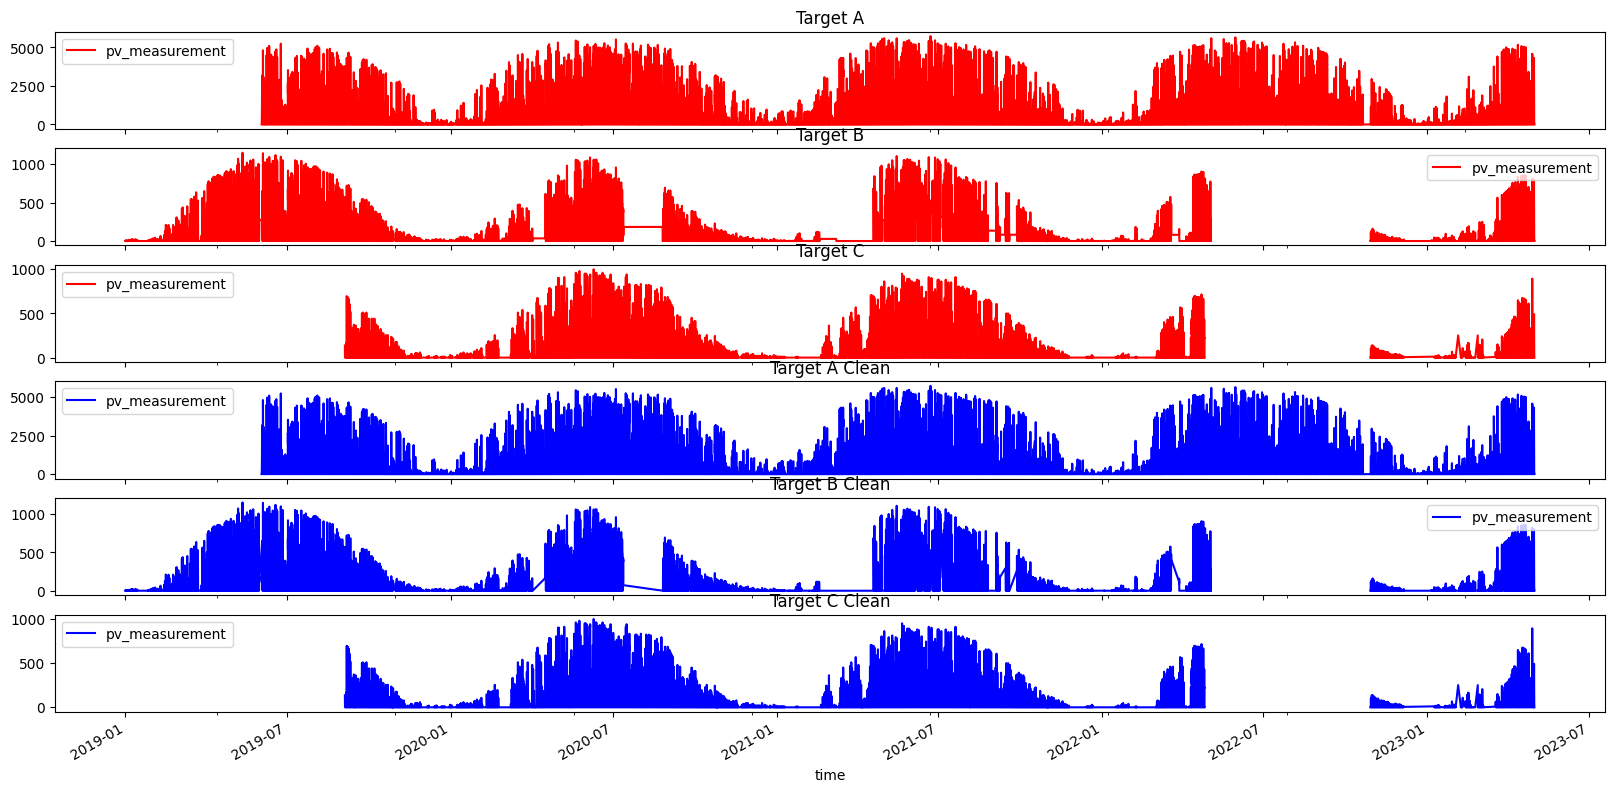

In [5]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [6]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [7]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  25996 25996
x,y:  23099 23099


In [8]:
X_train[0].tail()

,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
34055,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,304.939240,-0.18050,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0
34056,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,318.625763,-5.17600,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0
34057,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,332.785736,-8.95075,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0
34058,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,347.377991,-11.23325,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0
34059,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,92.209503,-11.84150,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0


# Feature engineering

In [9]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = train.append(test, ignore_index = True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_48981/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_48981/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_48981/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)


## Data Cleaning

In [10]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,3609,4342
cloud_base_agl:m,2362,1367,1686
snow_density:kgm3,32920,24141,21686


In [11]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [12]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

## Dropping suspects

suspects pressure does little for our model, trying to drop

#### Pre-drop: 
```sh
181/181 [==============================] - 0s 437us/step - loss: 653874.7500 - mae: 212.0931 - mse: 653874.7500
[653874.75, 212.09307861328125, 653874.75]
139/139 [==============================] - 0s 426us/step - loss: 7762.0210 - mae: 35.0129 - mse: 7762.0210
[7762.02099609375, 35.01294708251953, 7762.02099609375]
123/123 [==============================] - 0s 392us/step - loss: 2964.5674 - mae: 23.3109 - mse: 2964.5674
[2964.5673828125, 23.31093978881836, 2964.5673828125]
```
![Pre drop](./img/TF_out/31.10_no_FE.png)

#### Dropping test 1: 
```python
drop_cols = [
    'absolute_humidity_2m:gm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'sfc_pressure:hPa',
    'relative_humidity_1000hPa:p',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms'
    
]
```

```sh
181/181 [==============================] - 0s 432us/step - loss: 197970.0000 - mae: 205.1004 - mse: 197970.0000
[197970.0, 205.10043334960938, 197970.0]
139/139 [==============================] - 0s 417us/step - loss: 5838.9165 - mae: 33.0728 - mse: 5838.9165
[5838.91650390625, 33.07276153564453, 5838.91650390625]
123/123 [==============================] - 0s 401us/step - loss: 3120.2676 - mae: 24.0574 - mse: 3120.2676
[3120.267578125, 24.057418823242188, 3120.267578125]
```

Tells us these columns had little impact on the model as is?

#### Dropping test 2: 
```python
drop_cols = [
    'absolute_humidity_2m:gm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'msl_pressure:hPa',
    'sfc_pressure:hPa',
    'relative_humidity_1000hPa:p',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    'fresh_snow_12h:cm',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_24h:cm',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2'

]
```

```sh
181/181 [==============================] - 0s 418us/step - loss: 208691.7500 - mae: 211.6577 - mse: 208691.7500
[208691.75, 211.65774536132812, 208691.75]
139/139 [==============================] - 0s 395us/step - loss: 5031.0190 - mae: 31.5802 - mse: 5031.0190
[5031.01904296875, 31.580167770385742, 5031.01904296875]
123/123 [==============================] - 0s 380us/step - loss: 3350.0034 - mae: 25.1276 - mse: 3350.0034
[3350.00341796875, 25.127567291259766, 3350.00341796875]
```
almost identical to previous scores

#### Drop test 3

```python
drop_cols = [
    'absolute_humidity_2m:gm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'msl_pressure:hPa',
    'sfc_pressure:hPa',
    'relative_humidity_1000hPa:p',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    'fresh_snow_12h:cm',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_24h:cm',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2',
    'diffuse_rad:W',
    'diffuse_rad_1h:J'
]
```

```sh
181/181 [==============================] - 0s 556us/step - loss: 195659.1562 - mae: 203.1893 - mse: 195659.1562
[195659.15625, 203.1892852783203, 195659.15625]
139/139 [==============================] - 0s 479us/step - loss: 4931.4136 - mae: 31.6864 - mse: 4931.4136
[4931.41357421875, 31.686386108398438, 4931.41357421875]
123/123 [==============================] - 0s 402us/step - loss: 3084.2542 - mae: 23.9441 - mse: 3084.2542
[3084.254150390625, 23.944120407104492, 3084.254150390625]
```
Same same, seems like B is the only one loosing MAE over reduction in columns

#### Drop test 4
```py
drop_cols = [
    'absolute_humidity_2m:gm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'msl_pressure:hPa',
    'sfc_pressure:hPa',
    'relative_humidity_1000hPa:p',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    'fresh_snow_12h:cm',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_24h:cm',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2',
    'diffuse_rad:W',
    'diffuse_rad_1h:J',
    'air_density_2m:kgm3',
    'ceiling_height_agl:m',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'visibility:m'
]
```

```sh
181/181 [==============================] - 0s 422us/step - loss: 180758.4531 - mae: 197.2679 - mse: 180758.4531
[180758.453125, 197.2678680419922, 180758.453125]
139/139 [==============================] - 0s 426us/step - loss: 5472.1460 - mae: 32.1428 - mse: 5472.1460
[5472.14599609375, 32.142765045166016, 5472.14599609375]
123/123 [==============================] - 0s 411us/step - loss: 3101.2175 - mae: 23.5655 - mse: 3101.2175
[3101.217529296875, 23.56553077697754, 3101.217529296875]
```

slight improvement on A

#### Drop test 5

```py
h1_cols = [
    'diffuse_rad_1h:J',
    'clear_sky_energy_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm'
]
```

Removing 1h columns as well

```
181/181 [==============================] - 0s 430us/step - loss: 214305.6406 - mae: 218.3515 - mse: 214305.6406 -> A
[214305.640625, 218.35145568847656, 214305.640625]
139/139 [==============================] - 0s 420us/step - loss: 5198.0806 - mae: 30.8275 - mse: 5198.0806 -> B
[5198.08056640625, 30.82754898071289, 5198.08056640625]
123/123 [==============================] - 0s 409us/step - loss: 3501.0308 - mae: 24.2133 - mse: 3501.0308 -> C
[3501.03076171875, 24.213289260864258, 3501.03076171875]
```

Got worse A. 

#### Learned drop

Seems like the positive aspects of dropping came from : 

```py
    'air_density_2m:kgm3',
    'ceiling_height_agl:m',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'visibility:m'
```

Trying to drop ONLY these

```SH
181/181 [==============================] - 0s 443us/step - loss: 189200.5781 - mae: 193.6270 - mse: 189200.5781 -> A
[189200.578125, 193.62701416015625, 189200.578125]
139/139 [==============================] - 0s 425us/step - loss: 6743.2100 - mae: 35.8376 - mse: 6743.2100 -> B
[6743.2099609375, 35.8376350402832, 6743.2099609375]
123/123 [==============================] - 0s 391us/step - loss: 9743.8486 - mae: 24.1290 - mse: 9743.8486 -> C
[9743.8486328125, 24.128999710083008, 9743.8486328125]
```

Maybe only dropping these on A, with snow?

```sh
181/181 [==============================] - 0s 429us/step - loss: 195161.8438 - mae: 200.0833 - mse: 195161.8438
[195161.84375, 200.083251953125, 195161.84375]
139/139 [==============================] - 0s 396us/step - loss: 44856.2734 - mae: 33.1772 - mse: 44856.2734
[44856.2734375, 33.1772346496582, 44856.2734375]
123/123 [==============================] - 0s 402us/step - loss: 2895.2969 - mae: 23.1241 - mse: 2895.2969
[2895.296875, 23.12409019470215, 2895.296875]
```

Tenkeboks


In [13]:
X_train[0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_day:idx,34060.0,0.486524,0.499826,0.000000,0.000000,0.000000e+00,1.000000,1.000000e+00
is_in_shadow:idx,34060.0,0.526395,0.499310,0.000000,0.000000,1.000000e+00,1.000000,1.000000e+00
absolute_humidity_2m:gm3,34060.0,6.322360,2.799474,0.700000,4.200000,5.800000e+00,8.250000,1.735000e+01
air_density_2m:kgm3,34060.0,1.253279,0.037206,1.145000,1.227500,1.251500e+00,1.277250,1.426250e+00
ceiling_height_agl:m,34060.0,6036.402832,6939.430176,27.849998,1286.950012,2.651512e+03,7567.643433,2.000000e+04
clear_sky_energy_1h:J,34060.0,552687.375000,848346.125000,0.000000,0.000000,2.167836e+04,892444.875000,2.988628e+06
clear_sky_rad:W,34060.0,153.524185,236.246735,0.000000,0.000000,3.525000e+00,251.943752,8.351000e+02
cloud_base_agl:m,34060.0,2995.989746,4958.337402,27.799999,617.068756,1.255150e+03,2485.793762,2.000000e+04
dew_point_2m:K,34060.0,275.971863,6.892414,251.074997,271.299988,2.760000e+02,281.349976,2.936250e+02
diffuse_rad:W,34060.0,42.071201,62.839035,0.000000,0.000000,2.075000e+00,70.699997,3.322750e+02


In [14]:
drop_cols = [
    'absolute_humidity_2m:gm3',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'msl_pressure:hPa',
    'sfc_pressure:hPa',
    'relative_humidity_1000hPa:p',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    'fresh_snow_12h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_24h:cm',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2',
    'diffuse_rad:W',
    'air_density_2m:kgm3',
    'ceiling_height_agl:m',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'visibility:m'
]

h1_cols = [
    'diffuse_rad_1h:J',
    'clear_sky_energy_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm'
]
positive_col = [
    'fresh_snow_12h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_24h:cm',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2',
    'air_density_2m:kgm3',
    'ceiling_height_agl:m',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'visibility:m'
]

# for i in range(len(X_train)):
#     X_train[i].drop(columns=positive_col, inplace=True)
#     X_frames_test[i].drop(columns=positive_col, inplace=True)

X_train[0].drop(columns=positive_col, inplace=True)
X_frames_test[0].drop(columns=positive_col, inplace=True)



# Training the model

In [15]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=None)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=None)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=None)

In [16]:
import tensorflow as tf

normalizer_A = tf.keras.layers.Normalization(axis=-1)
normalizer_A.adapt(X_train[0])

first = np.array(X_train[0][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_A(first).numpy())

normalizer_B = tf.keras.layers.Normalization(axis=-1)
normalizer_B.adapt(X_train[1])
normalizer_C = tf.keras.layers.Normalization(axis=-1)
normalizer_C.adapt(X_train[2])

First example: [[   0.      1.      7.7     0.      0.      0.      0.      0.      0.
    99.07    0.   1006.3     0.    993.75  999.78    0.      0.     71.67
  1005.8   348.04   -3.77    0.    286.23  100.      3.6    -3.57   -0.5
     0.     -0.5     0.87    0.49   -0.87    0.      1.      0.      1.
     0.      0.      0.      0.  ]]

Normalized: [[-0.97  0.95  0.49 -0.65 -0.65 -0.67 -0.68 -0.46 -0.46  0.93 -0.09 -0.26
  -0.2  -0.23 -0.24 -0.08 -0.25 -0.17 -0.25  1.72 -0.15 -0.54  0.94  0.77
   0.3  -1.46 -0.58 -0.01 -0.71  1.22  0.71 -1.25 -0.09  0.19 -0.17  0.24
  -0.21 -0.07 -0.08 -0.01]]


In [17]:
def build_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(64, activation="relu", input_shape=[len(X_train[0].keys())]),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    optim = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse", optimizer=optim, metrics=["mae", "mse"])

    return model

In [18]:
model_a = build_model(normalizer_A)
model_b = build_model(normalizer_B)
model_c = build_model(normalizer_C)

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_a = model_a.fit(
    x_train_a,
    y_train_a,
    validation_split=0.2,
    epochs=1000, 
    callbacks=[early_stop])

history_b = model_b.fit(
    x_train_b,
    y_train_b,
    validation_split=0.2,
    epochs=1000, 
    callbacks=[early_stop])

history_c = model_c.fit(
    x_train_c,
    y_train_c,
    validation_split=0.2,
    epochs=1000, 
    callbacks=[early_stop])

Epoch 1/1000
707/707 [==============================] - 1s 656us/step - loss: 659995.3125 - mae: 365.4525 - mse: 659995.3125 - val_loss: 238067.2500 - val_mae: 248.4686 - val_mse: 238067.2500
Epoch 2/1000
707/707 [==============================] - 0s 543us/step - loss: 219631.4688 - mae: 237.7674 - mse: 219631.4688 - val_loss: 217591.8906 - val_mae: 235.4326 - val_mse: 217591.8906
Epoch 3/1000
707/707 [==============================] - 0s 528us/step - loss: 210756.0000 - mae: 229.9356 - mse: 210756.0000 - val_loss: 215918.7344 - val_mae: 230.1554 - val_mse: 215918.7344
Epoch 4/1000
707/707 [==============================] - 0s 523us/step - loss: 208159.5469 - mae: 225.1077 - mse: 208159.5469 - val_loss: 212553.0938 - val_mae: 225.7644 - val_mse: 212553.0938
Epoch 5/1000
707/707 [==============================] - 0s 558us/step - loss: 205788.6875 - mae: 220.3152 - mse: 205788.6875 - val_loss: 211925.5000 - val_mae: 223.6442 - val_mse: 211925.5000
Epoch 6/1000
707/707 [==================

In [20]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['mae'], label='MAE')
  plt.plot(history.history['val_mae'], label='VAL_MAE')
  plt.ylim([0, 250])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

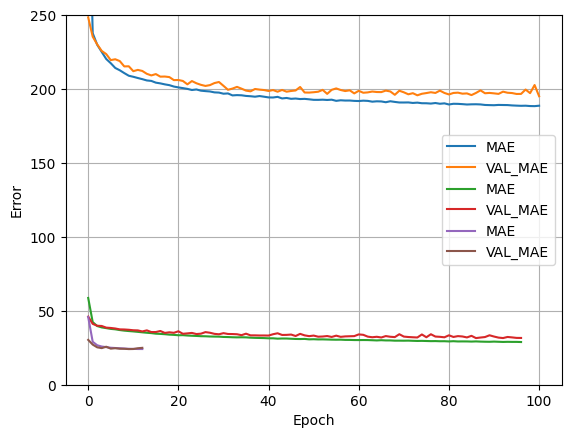

In [21]:
plot_loss(history_a)
plot_loss(history_b)
plot_loss(history_c)


In [26]:
print(model_a.evaluate(x_val_a, y_val_a))
print(model_b.evaluate(x_val_b, y_val_b))
print(model_c.evaluate(x_val_c, y_val_c))

181/181 [==============================] - 0s 429us/step - loss: 195161.8438 - mae: 200.0833 - mse: 195161.8438
[195161.84375, 200.083251953125, 195161.84375]
139/139 [==============================] - 0s 396us/step - loss: 44856.2734 - mae: 33.1772 - mse: 44856.2734
[44856.2734375, 33.1772346496582, 44856.2734375]
123/123 [==============================] - 0s 402us/step - loss: 2895.2969 - mae: 23.1241 - mse: 2895.2969
[2895.296875, 23.12409019470215, 2895.296875]


# Make predictions

In [ ]:
# Do some more stuff

# Evaluate prediction

In [ ]:

# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_a, 'A'), (model_b, 'B'), (model_c, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    
    print(f'Model {model[1]}')
    print(feature_importance_df1.head(10))
    print('')


# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)